In [16]:
#START HERE#
#Open Libraries - Run every time
library(Seurat)
library(ggplot2)
library(dplyr)
library("EnhancedVolcano")
library(tictoc)
set.seed(42)

load("/Users/yzhou14/Data_local/20200627_scRNAseq_analysis/Colon_0.6_0730.RDS")
#after this step, an object named immune.combined is loaded
# we only choose the singlet for downstream analysis
immune.combined=subset(immune.combined,`DF`=="Singlet")

In [18]:
immune.combined[["celltype0627_stim"]]<- paste(Idents(immune.combined), immune.combined$stim, sep = "_")

In [17]:
head(immune.combined[[]])

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,stim,nCount_SCT,nFeature_SCT,SCT_snn_res.0.6,seurat_clusters,celltype0627,celltype0627_stim,bc,DF,doublet
,<chr>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<int>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<dbl>
AAACCCAAGCATTGTC_1,WILD_TYPE,2189,712,1.598904,WTI,1502,678,6,6,6.IgA+ Plasma B,6.IgA+ Plasma B_WTI,AAACCCAAGCATTGTC_1,Singlet,0.10169492
AAACCCAAGCCTCAAT_1,WILD_TYPE,1200,631,4.333333,WTI,1175,631,1,1,1.IgM+IgD+ mature B,1.IgM+IgD+ mature B_WTI,AAACCCAAGCCTCAAT_1,Singlet,0.27118644
AAACCCAAGTGACACG_1,WILD_TYPE,889,577,4.611924,WTI,940,577,10,10,"10.CD8+ T, NKT","10.CD8+ T, NKT_WTI",AAACCCAAGTGACACG_1,Singlet,0.05084746
AAACCCACAGGACGAT_1,WILD_TYPE,1968,524,9.247967,WTI,1415,496,6,6,6.IgA+ Plasma B,6.IgA+ Plasma B_WTI,AAACCCACAGGACGAT_1,Singlet,0.01694915
AAACCCACATGGAACG_1,WILD_TYPE,664,415,1.957831,WTI,843,415,0,0,0.IgD+ mature B,0.IgD+ mature B_WTI,AAACCCACATGGAACG_1,Singlet,0.05084746
AAACGAACATCCAATG_1,WILD_TYPE,428,284,3.271028,WTI,853,301,0,0,0.IgD+ mature B,0.IgD+ mature B_WTI,AAACGAACATCCAATG_1,Singlet,0.00000000


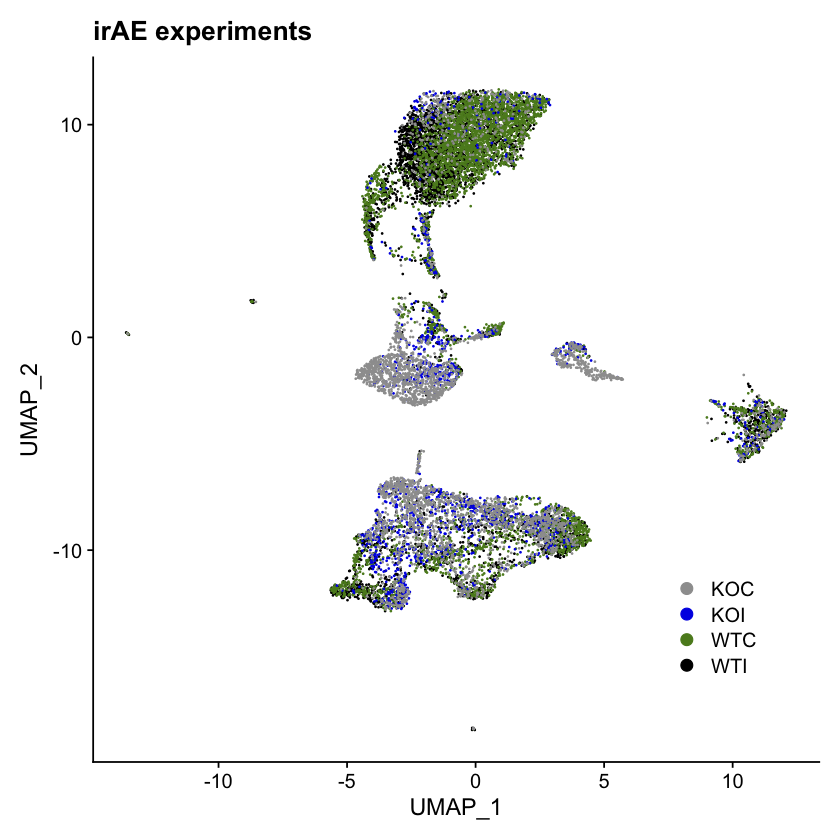

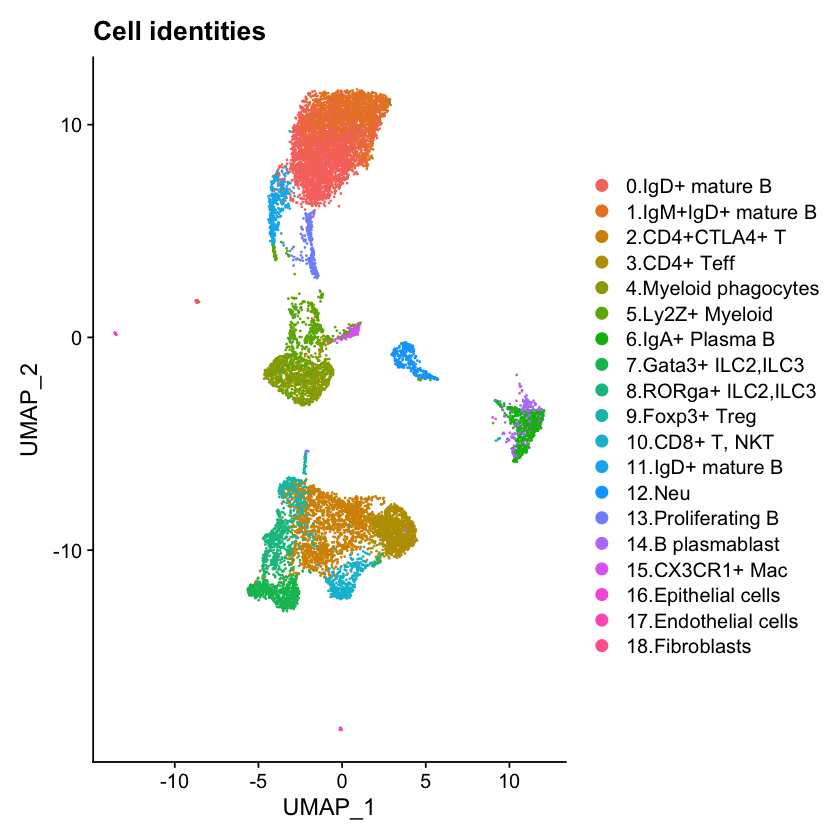

In [19]:
# UMAP for the experiment design
colormap.irAE_experiments=c("WTI"="#000000","WTC"="#5C8924","KOI"="#0715e5","KOC"="#8e1098")
DimPlot(immune.combined, reduction = "umap", 
        group.by = "stim", pt.size=0.1,
        cols=colormap.irAE_experiments)+s
ggtitle("irAE experiments")+
theme(legend.position = c(0.8,0.2))

# UMAP for the cell type
DimPlot(immune.combined, reduction = "umap", 
        group.by="celltype0627", pt.size=0.1)+
ggtitle("Cell identities")

In [21]:
table(immune.combined$celltype0627_stim)


     0.IgD+ mature B_KOC      0.IgD+ mature B_KOI      0.IgD+ mature B_WTC 
                     138                       27                     1192 
     0.IgD+ mature B_WTI  1.IgM+IgD+ mature B_KOC  1.IgM+IgD+ mature B_KOI 
                    1916                      155                       78 
 1.IgM+IgD+ mature B_WTC  1.IgM+IgD+ mature B_WTI       10.CD8+ T, NKT_KOC 
                    1157                      375                       99 
      10.CD8+ T, NKT_KOI       10.CD8+ T, NKT_WTC       10.CD8+ T, NKT_WTI 
                      17                      118                      127 
    11.IgD+ mature B_KOC     11.IgD+ mature B_KOI     11.IgD+ mature B_WTC 
                       4                        8                      203 
    11.IgD+ mature B_WTI               12.Neu_KOC               12.Neu_KOI 
                     138                      251                       54 
              12.Neu_WTC               12.Neu_WTI   13.Proliferating B_KOC 
           

# DEG utilities

In [4]:
############  some snippet necessary for DEG analysis ############ 
### define a function to clean the DEG results
filter.deg<- function(markers, p_val_adj.cutoff=0.05, avg_logFC.cutoff=0, pct.1.cutoff=0, pct.2.cutoff=1){
  markers<-markers[markers$p_val_adj<p_val_adj.cutoff, ]
  markers<-markers[markers$avg_logFC>avg_logFC.cutoff, ]
  markers<-markers[markers$pct.1 > pct.1.cutoff, ]
  markers<-markers[markers$pct.2 < pct.2.cutoff, ]
  markers$gene  <-  rownames(markers)
  markers$log2FC<-  log2(exp(markers$avg_logFC))
  markers$FC    <-  exp(markers$avg_logFC)
  return(markers[order(-markers$avg_logFC), ])
}
### load gene list necessary for gene annotation from github
load(url("https://github.com/chansigit/SSAT/raw/master/mm.cellsurfacemarker.rda"))
load(url("https://github.com/chansigit/SSAT/raw/master/mm.secretory.rda"))
load(url("https://github.com/chansigit/SSAT/raw/master/mm.tf.rda"))

### load gene annotation function from github
source("https://raw.github.com/chansigit/SSAT/master/annotate.genelist.R")

#######  some snippet necessary for DEG analysis (end) ########### 

In [22]:
# one-dragon-run 
# batch processing for high throughput DEG identifications
DefaultAssay(immune.combined)<-"RNA" # always remember to use RNA slot for DEG analysis
Idents(immune.combined)<-"celltype0627_stim"
seu <- immune.combined

#set the working directory to save results
setwd("/Users/yzhou14/Data_local/20200802 with Sijie for fig/DEG_analysis_results_dbltFree/")
for (celltype in levels(seu$celltype0627)){   # 16 17 18 had failed
    for (cmp in c("KOI.vs.KOC", "WTI.vs.WTC", "WTI.vs.KOI", "WTC.vs.KOC")){
        if (cmp=="KOI.vs.KOC"){
            cmp1=paste(celltype, "_KOI", sep="")
            cmp2=paste(celltype, "_KOC", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }else if (cmp=="WTI.vs.WTC"){
            cmp1=paste(celltype, "_WTI", sep="")
            cmp2=paste(celltype, "_WTC", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }else if (cmp=="WTI.vs.KOI"){
            cmp1=paste(celltype, "_WTI", sep="")
            cmp2=paste(celltype, "_KOI", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }else if (cmp=="WTC.vs.KOC"){
            cmp1=paste(celltype, "_WTC", sep="")
            cmp2=paste(celltype, "_KOC", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }
        cat(deg.design)
        
        markers1 <- FindMarkers(seu, ident.1 = cmp1, ident.2 = cmp2, verbose = F, only.pos=T, slot = "data",assay = "RNA")
        markers1 <- filter.deg(markers1, p_val_adj.cutoff=0.05)
        markers1 <- annotate.genelist(markers1, tf=mm.tf, surface=mm.cellsurfacemarker, secretory=mm.secretory)
        if (nrow(markers1)>0){
            markers1$cluster  <- cmp1
        }else{
            markers1$cluster  <- c()
        }
        
        markers1$avg_logFC= -markers1$avg_logFC
        markers1$log2FC   = -markers1$log2FC
        
        markers2 <- FindMarkers(seu, ident.1 = cmp2, ident.2 = cmp1, verbose = F, only.pos=T, slot = "data",assay = "RNA")
        markers2 <- filter.deg(markers2, p_val_adj.cutoff=0.05)
        markers2 <- annotate.genelist(markers2, tf=mm.tf, surface=mm.cellsurfacemarker, secretory=mm.secretory)
        if (nrow(markers2)>0){
            markers2$cluster  <- cmp2
        }else{
            markers2$cluster  <- c()
        }
        
        markers <- rbind(markers1, markers2)
        if (nrow(markers)>0){
            plot<-EnhancedVolcano(markers, lab=rownames(markers), x="log2FC", y="p_val_adj", 
                                  title=deg.design, subtitle = "CTRL condition's markers have negative FCs, vice versa ", 
                                  pCutoff=.05, labSize=6, FCcutoff=.3)
            pdf(file=paste(deg.design,".pdf",sep=""),width = 10, height = 8)
            print(plot)
            dev.off()
            write.csv(markers, file=paste(deg.design, ".csv", sep="") )
        }
    }
}



0.IgD+ mature B_KOI  vs  0.IgD+ mature B_KOC 


Warning message:
“Removed 1 rows containing missing values (geom_vline).”


0.IgD+ mature B_WTI  vs  0.IgD+ mature B_WTC 
0.IgD+ mature B_WTI  vs  0.IgD+ mature B_KOI 
0.IgD+ mature B_WTC  vs  0.IgD+ mature B_KOC 
1.IgM+IgD+ mature B_KOI  vs  1.IgM+IgD+ mature B_KOC 
1.IgM+IgD+ mature B_WTI  vs  1.IgM+IgD+ mature B_WTC 
1.IgM+IgD+ mature B_WTI  vs  1.IgM+IgD+ mature B_KOI 
1.IgM+IgD+ mature B_WTC  vs  1.IgM+IgD+ mature B_KOC 
2.CD4+CTLA4+ T_KOI  vs  2.CD4+CTLA4+ T_KOC 
2.CD4+CTLA4+ T_WTI  vs  2.CD4+CTLA4+ T_WTC 
2.CD4+CTLA4+ T_WTI  vs  2.CD4+CTLA4+ T_KOI 
2.CD4+CTLA4+ T_WTC  vs  2.CD4+CTLA4+ T_KOC 
3.CD4+ Teff_KOI  vs  3.CD4+ Teff_KOC 
3.CD4+ Teff_WTI  vs  3.CD4+ Teff_WTC 
3.CD4+ Teff_WTI  vs  3.CD4+ Teff_KOI 
3.CD4+ Teff_WTC  vs  3.CD4+ Teff_KOC 
4.Myeloid phagocytes_KOI  vs  4.Myeloid phagocytes_KOC 
4.Myeloid phagocytes_WTI  vs  4.Myeloid phagocytes_WTC 
4.Myeloid phagocytes_WTI  vs  4.Myeloid phagocytes_KOI 
4.Myeloid phagocytes_WTC  vs  4.Myeloid phagocytes_KOC 
5.Ly2Z+ Myeloid_KOI  vs  5.Ly2Z+ Myeloid_KOC 
5.Ly2Z+ Myeloid_WTI  vs  5.Ly2Z+ Myeloid_WTC 
5.

Warning message:
“Removed 1 rows containing missing values (geom_vline).”


7.Gata3+ ILC2,ILC3_WTI  vs  7.Gata3+ ILC2,ILC3_WTC 
7.Gata3+ ILC2,ILC3_WTI  vs  7.Gata3+ ILC2,ILC3_KOI 
7.Gata3+ ILC2,ILC3_WTC  vs  7.Gata3+ ILC2,ILC3_KOC 
8.RORga+ ILC2,ILC3_KOI  vs  8.RORga+ ILC2,ILC3_KOC 


Warning message:
“Removed 1 rows containing missing values (geom_vline).”


8.RORga+ ILC2,ILC3_WTI  vs  8.RORga+ ILC2,ILC3_WTC 
8.RORga+ ILC2,ILC3_WTI  vs  8.RORga+ ILC2,ILC3_KOI 
8.RORga+ ILC2,ILC3_WTC  vs  8.RORga+ ILC2,ILC3_KOC 
9.Foxp3+ Treg_KOI  vs  9.Foxp3+ Treg_KOC 
9.Foxp3+ Treg_WTI  vs  9.Foxp3+ Treg_WTC 
9.Foxp3+ Treg_WTI  vs  9.Foxp3+ Treg_KOI 


Warning message:
“Removed 1 rows containing missing values (geom_vline).”


9.Foxp3+ Treg_WTC  vs  9.Foxp3+ Treg_KOC 
10.CD8+ T, NKT_KOI  vs  10.CD8+ T, NKT_KOC 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


10.CD8+ T, NKT_WTI  vs  10.CD8+ T, NKT_WTC 
10.CD8+ T, NKT_WTI  vs  10.CD8+ T, NKT_KOI 
10.CD8+ T, NKT_WTC  vs  10.CD8+ T, NKT_KOC 
11.IgD+ mature B_KOI  vs  11.IgD+ mature B_KOC 
11.IgD+ mature B_WTI  vs  11.IgD+ mature B_WTC 
11.IgD+ mature B_WTI  vs  11.IgD+ mature B_KOI 


Warning message:
“Removed 1 rows containing missing values (geom_vline).”


11.IgD+ mature B_WTC  vs  11.IgD+ mature B_KOC 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


12.Neu_KOI  vs  12.Neu_KOC 
12.Neu_WTI  vs  12.Neu_WTC 
12.Neu_WTI  vs  12.Neu_KOI 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


12.Neu_WTC  vs  12.Neu_KOC 
13.Proliferating B_KOI  vs  13.Proliferating B_KOC 
13.Proliferating B_WTI  vs  13.Proliferating B_WTC 
13.Proliferating B_WTI  vs  13.Proliferating B_KOI 
13.Proliferating B_WTC  vs  13.Proliferating B_KOC 
14.B plasmablast_KOI  vs  14.B plasmablast_KOC 
14.B plasmablast_WTI  vs  14.B plasmablast_WTC 
14.B plasmablast_WTI  vs  14.B plasmablast_KOI 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


14.B plasmablast_WTC  vs  14.B plasmablast_KOC 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


15.CX3CR1+ Mac_KOI  vs  15.CX3CR1+ Mac_KOC 
15.CX3CR1+ Mac_WTI  vs  15.CX3CR1+ Mac_WTC 
15.CX3CR1+ Mac_WTI  vs  15.CX3CR1+ Mac_KOI 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


15.CX3CR1+ Mac_WTC  vs  15.CX3CR1+ Mac_KOC 


Warning message:
“Removed 2 rows containing missing values (geom_vline).”


16.Epithelial cells_KOI  vs  16.Epithelial cells_KOC 


ERROR: Error in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, : Cell group 1 has fewer than 3 cells


In [ ]:
# one-dragon-run 
# batch processing for high throughput DEG identifications
DefaultAssay(immune.combined)<-"RNA" # always remember to use RNA slot for DEG analysis
Idents(immune.combined)<-"celltype0627_stim"
seu <- immune.combined

#set the working directory to save results
setwd("/Users/yzhou14/Data_local/20200802 with Sijie for fig/DEG_analysis_results_dbltFree/WTI.vs.KOC/")
for (celltype in levels(seu$celltype0627)){   # 16 17 18 had failed
    for (cmp in c("WTI.vs.KOC")){
        if (cmp=="WTI.vs.KOC"){
            cmp1=paste(celltype, "_WTI", sep="")
            cmp2=paste(celltype, "_KOC", sep="")
            deg.design=(paste(cmp1," vs ",cmp2,"\n"))
        }
        cat(deg.design)
        
        markers1 <- FindMarkers(seu, ident.1 = cmp1, ident.2 = cmp2, verbose = F, only.pos=T, slot = "data",assay = "RNA")
        markers1 <- filter.deg(markers1, p_val_adj.cutoff=0.05)
        markers1 <- annotate.genelist(markers1, tf=mm.tf, surface=mm.cellsurfacemarker, secretory=mm.secretory)
        if (nrow(markers1)>0){
            markers1$cluster  <- cmp1
        }else{
            markers1$cluster  <- c()
        }
        
        markers1$avg_logFC= -markers1$avg_logFC
        markers1$log2FC   = -markers1$log2FC
        
        markers2 <- FindMarkers(seu, ident.1 = cmp2, ident.2 = cmp1, verbose = F, only.pos=T, slot = "data",assay = "RNA")
        markers2 <- filter.deg(markers2, p_val_adj.cutoff=0.05)
        markers2 <- annotate.genelist(markers2, tf=mm.tf, surface=mm.cellsurfacemarker, secretory=mm.secretory)
        if (nrow(markers2)>0){
            markers2$cluster  <- cmp2
        }else{
            markers2$cluster  <- c()
        }
        
        markers <- rbind(markers1, markers2)
        if (nrow(markers)>0){
            plot<-EnhancedVolcano(markers, lab=rownames(markers), x="log2FC", y="p_val_adj", 
                                  title=deg.design, subtitle = "CTRL condition's markers have negative FCs, vice versa ", 
                                  pCutoff=.05, labSize=6, FCcutoff=.3)
            pdf(file=paste(deg.design,".pdf",sep=""),width = 10, height = 8)
            print(plot)
            dev.off()
            write.csv(markers, file=paste(deg.design, ".csv", sep="") )
        }
    }
}


